<a href="https://colab.research.google.com/github/marisbotero/computer_vision/blob/master/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 👕👝Clasificación de Ropa 👚🧥👟

---




Construiremos y entrenaremos una red neuronal para clasificar imágenes de ropa, como zapatillas y camisetas.


##  🖤 ¿Como se puede clasificar imagénes?

La CNN es un tipo de Red Neuronal Artificial con aprendizaje supervisado que procesa sus capas imitando al cortex visual del ojo humano para identificar distintas características en las entradas que en definitiva hacen que pueda identificar objetos y «ver». Para ello, la CNN contiene varias capas ocultas especializadas y con una jerarquía: esto quiere decir que las primeras capas pueden detectar lineas, curvas y se van especializando hasta llegar a capas más profundas que reconocen formas complejas como un rostro o la silueta de un animal.

## 💛Pixeles y neuronas

Para comenzar, la red toma como entrada los pixeles de una imagen. Si tenemos una imagen con apenas 28×28 pixeles de alto y ancho, eso equivale a  784 neuronas. Y eso es si sólo tenemos 1 color (escala de grises). Si tuviéramos una imagen a color, necesitaríamos 3 canales (red, green, blue) y entonces usaríamos 28x28x3 = 2352 neuronas de entrada. Esa es nuestra capa de entrada. 

## 💚Pre-procesamiento

Antes de alimentar la red, recuerda que como entrada nos conviene normalizar los valores. Los colores de los pixeles tienen valores que van de 0 a 255, haremos una transformación de cada pixel: «valor/255» y nos quedará siempre un valor entre 0 y 1.

##  💙Instalar e importar dependencias

Necesitaremos los conjuntos de datos TensorFlow, una API que simplifica la descarga y el acceso a los conjuntos de datos, y proporciona varios conjuntos de datos de muestra para trabajar.

In [0]:
!pip install -U tensorflow_datasets

     |████████████████████████████████| 686kB 4.8MB/s 


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals


# Import TensorFlow and TensorFlow Datasets
import tensorflow as tf
import tensorflow_datasets as tfds
tf.logging.set_verbosity(tf.logging.ERROR)

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

# Improve progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm


print(tf.__version__)

# This will go away in the future.
# If this gives an error, you might be running TensorFlow 2 or above
# If so, then just comment out this line and run this cell again
tf.enable_eager_execution() 

1.13.1


Esta guía utiliza el conjunto de datos Fashion MNIST, que contiene 70,000 imágenes en escala de grises en 10 categorías. Las imágenes muestran artículos individuales de ropa a baja resolución (28 × 28 píxeles).

In [0]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/1.0.0. Subsequent calls will reuse this data.



💚🧡💜
El propósito de la moda MNIST es un reemplazo directo del conjunto de datos clásico del MNIST, que a menudo se usa como el "Hola, Mundo" de los programas de aprendizaje automático para la visión por computadora. El conjunto de datos MNIST contiene imágenes de dígitos escritos a mano (0, 1, 2, etc.).
.

Para el ejercicio usaremos 60,000 imágenes para entrenar la red y 10,000 imágenes para evaluar con qué precisión aprendió la red para clasificar las imágenes. Puede acceder al Fashion MNIST directamente desde TensorFlow, utilizando la API de conjuntos de datos:

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

La carga del conjunto de datos devuelve metadatos, así como un conjunto de datos de entrenamiento y un conjunto de datos de prueba.


*   El modelo se entrena usando train_dataset.
*   El modelo está probado contra test_dataset.


*   Las imágenes son matrices de 28 × 28, con valores de píxeles en el rango [0, 255]. Las etiquetas son una matriz de enteros, en el rango [0, 9]. Estos corresponden a la clase de vestimenta que representa la imagen.





Cada imagen se asigna a una sola etiqueta. Dado que los nombres de clase no se incluyen con el conjunto de datos, guárdelos aquí para usarlos más adelante al trazar las imágenes:

In [0]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


In [0]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

## Explora los datos procesados 🧐

Vamos a trazar una imagen para ver cómo se ve.

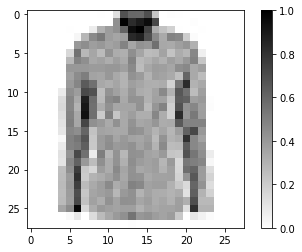

In [0]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

🧠 Ahora vamos a mostrar las primeras 25 imágenes del conjunto de entrenamiento con el nombre de la clase debajo de cada imagen. Es importante revisar que los datos estén en el formato correcto y estamos listos para construir y  entrenar  la red.

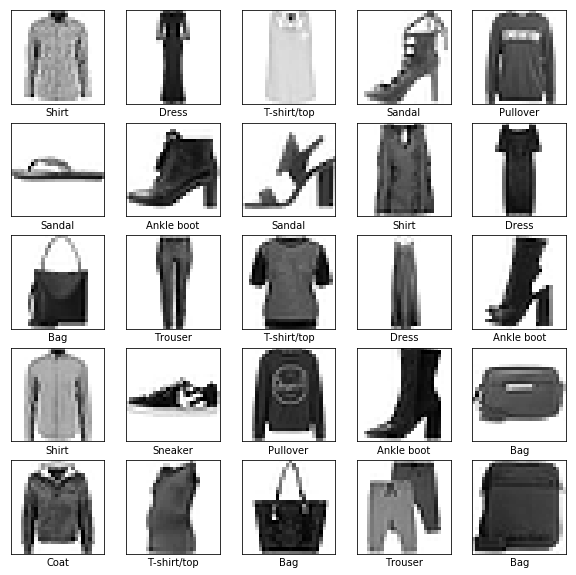

In [0]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

## Construir el modelo 💜

La construcción de la red neuronal requiere configurar las capas del modelo y luego compilar el modelo.




### Configurar las capas


*   El bloque de construcción básico de una red neuronal es la capa. Una capa extrae una representación de los datos introducidos en ella. Con suerte, una serie de capas conectadas da como resultado una representación que es significativa para el problema en cuestión.
*   Gran parte del aprendizaje profundo consiste en encadenar capas simples. La mayoría de las capas, como tf.keras.layers.Dense, tienen parámetros internos que se ajustan ("aprenden") durante el entrenamiento.





In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

### Esta red tiene tres capas:


* **input** `tf.keras.layers.Flatten`: esta capa transforma las imágenes de una matriz 2d de 28 $ \ veces $ 28 píxeles, a una matriz 1d de 784 píxeles (28 \ * 28). Piense en esta capa como filas de píxeles desapiladas en la imagen y alineandolas. Esta capa no tiene parámetros que aprender, ya que solo reformatea los datos.

* **"hidden"** `tf.keras.layers.Dense`:una capa densamente conectada de 128 neuronas. Cada neurona (o nodo) toma la entrada de los 784 nodos de la capa anterior, ponderando esa entrada de acuerdo con los parámetros ocultos que se aprenderán durante el entrenamiento, y envía un solo valor a la siguiente capa.

* **output** `tf.keras.layers.Dense`:Una capa de softmax * de 10 nodos, con cada nodo que representa una clase de ropa. Al igual que en la capa anterior, cada nodo toma la entrada de los 128 nodos en la capa anterior. Cada nodo pesa la entrada de acuerdo con los parámetros aprendidos y luego genera un valor en el rango `[0, 1]`, que representa la probabilidad de que la imagen pertenezca a esa clase. La suma de los 10 valores de nodo es 1.



### 🚀Compilar el modelo

Antes de que el modelo esté listo para el entrenamiento, necesita algunas configuraciones más.
* *Loss function* :  Un algoritmo para medir qué tan lejos están las salidas del modelo de la salida deseada. El objetivo del entrenamiento es medir la pérdida.

* *Optimizer* :un algoritmo para ajustar los parámetros internos del modelo para minimizar la pérdida.

* *Metrics*: se utiliza para monitorear los pasos de capacitación y pruebas. El siguiente ejemplo utiliza * precision *, la fracción de las imágenes que están clasificadas correctamente.


In [0]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


## Entrenamiento del modelo

Primero, definimos el comportamiento de iteración para el conjunto de datos :

1. Repeat forever by specifying `dataset.repeat():  (el parámetro  - epochs- descrito a continuación limita el tiempo que llevamos a cabo el entrenamiento).

2. The `dataset.shuffle(60000): aleatoriza el orden para que nuestro modelo no pueda aprender nada del orden de los ejemplos

3.  And `dataset.batch(32)` tells `model.fit` : que use lotes de 32 imágenes y etiquetas al actualizar las variables del modelo.

####📖 El entrenamiento se realiza llamando al método `model.fit`:
1. Alimente los datos de entrenamiento al modelo utilizando `train_dataset`.
2. El modelo aprende a asociar imágenes y etiquetas.
3. El parámetro `epochs = 5` limita el entrenamiento a 5 iteraciones completas del conjunto de datos de entrenamiento, por lo que un total de 5 * 60000 = 300000 ejemplos.



In [0]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [0]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 30s 16ms/step - loss: 0.4953 - acc: 0.8261
Epoch 2/5
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3750 - acc: 0.8648
Epoch 3/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.3360 - acc: 0.8759
Epoch 4/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.3117 - acc: 0.8856
Epoch 5/5
1875/1875 [==============================] - 20s 10ms/step - loss: 0.2930 - acc: 0.8919


👚👟A medida que el modelo se entrena, se muestran las métricas de pérdida y precisión. Este modelo alcanza una precisión de aproximadamente 0,88 (o 88%) en los datos de entrenamiento.

## Evaluar la precisión

Se  compara el rendimiento del modelo en el conjunto de datos de prueba. 

In [0]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 3s 8ms/step - loss: 0.3625 - acc: 0.8725
Accuracy on test dataset: 0.8725


Como resultado, la precisión en el conjunto de datos de prueba es menor que la precisión en el conjunto de datos de entrenamiento. Esto es completamente normal, ya que el modelo fue entrenado en el `train_dataset`. Cuando el modelo ve imágenes que nunca ha visto durante el entrenamiento, (es decir, del `test_dataset`), podemos esperar que el rendimiento disminuya.

## Hacer predicciones y explorar

Con el modelo entrenado, podemos usarlo para hacer predicciones sobre algunas imágenes.

In [0]:

for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [0]:
predictions.shape

(32, 10)

Aquí, el modelo ha predicho la etiqueta para cada imagen en el conjunto de pruebas. Echemos un vistazo a la primera predicción:

In [0]:
predictions[0]

array([6.16533507e-05, 1.98381116e-07, 1.32960575e-02, 8.36153777e-05,
       1.37596786e-01, 1.42713148e-07, 8.48945618e-01, 4.33169667e-10,
       1.58917537e-05, 4.69204586e-08], dtype=float32)

Una predicción es una matriz de 10 números. Estos describen la "confianza" del modelo de que la imagen corresponde a cada uno de los 10 artículos de ropa diferentes. Podemos ver qué etiqueta tiene el mayor valor de confianza:

In [0]:
np.argmax(predictions[0])

6

Así que el modelo está más seguro de que esta imagen es una camisa, o `class_names [6]`. Y podemos revisar la etiqueta de prueba para ver si esto es correcto:

In [0]:
test_labels[0]

6

Podemos graficar esto para ver el conjunto completo de 10 predicciones de clase

In [0]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Veamos la 0ª imagen, las predicciones y la matriz de predicción.

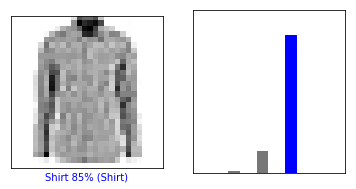

In [0]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

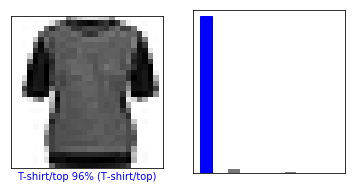

In [0]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

Vamos a trazar varias imágenes con sus predicciones. Las etiquetas de predicción correctas son azules y las etiquetas de predicción incorrectas son rojas. El número da el porcentaje (de 100) para la etiqueta predicha. Tenga en cuenta que puede ser incorrecto incluso cuando es muy seguro.

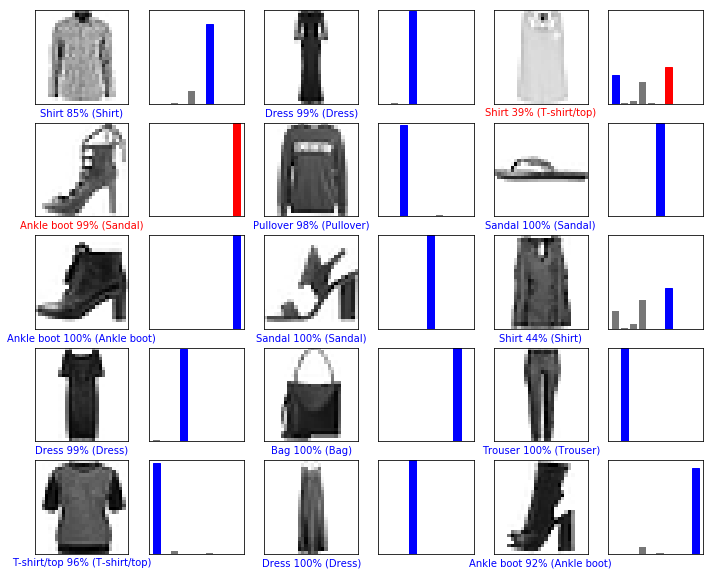

In [0]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


Finalmente, utilice el modelo entrenado para hacer una predicción sobre una sola imagen.

In [0]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


Los modelos `tf.keras` están optimizados para hacer predicciones en un * lote *, o colección, de ejemplos a la vez. Entonces, aunque estamos usando una sola imagen, necesitamos agregarla a una lista:

In [0]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


Ahora predice la imagen:

In [0]:
predictions_single = model.predict(img)

print(predictions_single)

[[6.1653394e-05 1.9838107e-07 1.3296055e-02 8.3615436e-05 1.3759702e-01
  1.4271366e-07 8.4894544e-01 4.3316956e-10 1.5891765e-05 4.6920359e-08]]


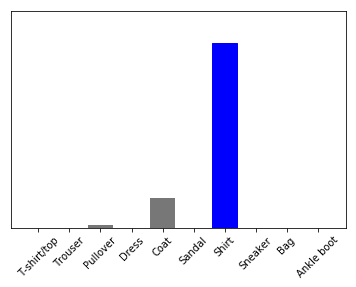

In [0]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [0]:
np.argmax(predictions_single[0])

6